# Exploring ASAP dataset

Dataset of [Aligned Scores and Performances](https://github.com/fosfrancesco/asap-dataset/tree/master)

In [1]:
import sys
sys.path.append("..")

from src.data import extract_piano_roll, calculate_cross_similarity
from src.utils import plot_piano_roll, plot_cross_similarity

import os
import json

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Path to the clonned ASAP repository

asap_dir = "../../asap-dataset"

In [3]:
annotations_path = os.path.join(asap_dir, 'asap_annotations.json')

In [4]:
with open(annotations_path, "r", encoding="utf8") as f:
    annotations = json.load(f)

In [5]:
print(f"Number of pieces in ASAP: {len(annotations)}")

Number of pieces in ASAP: 1067


Let's take a look at one of the performances of Schubert's Impromptu Op. 90 No. 2

In [6]:
piece_title = 'Schubert/Impromptu_op.90_D.899/2'
performer = 'Denisova11M.mid'
perf_title = os.path.join(piece_title, performer)
perf_path = os.path.join(asap_dir, perf_title)

score_path = os.path.join(asap_dir, piece_title, 'midi_score.mid')

In [7]:
list(annotations[perf_title].keys())

['performance_beats',
 'performance_downbeats',
 'performance_beats_type',
 'perf_time_signatures',
 'perf_key_signatures',
 'midi_score_beats',
 'midi_score_downbeats',
 'midi_score_beats_type',
 'midi_score_time_signatures',
 'midi_score_key_signatures',
 'downbeats_score_map',
 'score_and_performance_aligned']

In [8]:
print("Number of annotated beats in performance:",
      len(annotations[perf_title]['performance_beats']))

Number of annotated beats in performance: 848


In [9]:
print("Number of annotated beats in the score:",
      len(annotations[perf_title]['midi_score_beats']))

Number of annotated beats in the score: 848


As we can see, the number of annotated beats match.

In [10]:
# Sampling frequency for piano rolls
fs = 40

In [11]:
perf_roll = extract_piano_roll(perf_path, fs=fs)
perf_roll.shape

torch.Size([8934, 128])

/home/dmgvrlv/code/dcnn-alignment/notebooks/../src/utils.py:16: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(piano_roll.T.numpy()[start_pitch:end_pitch + 1],


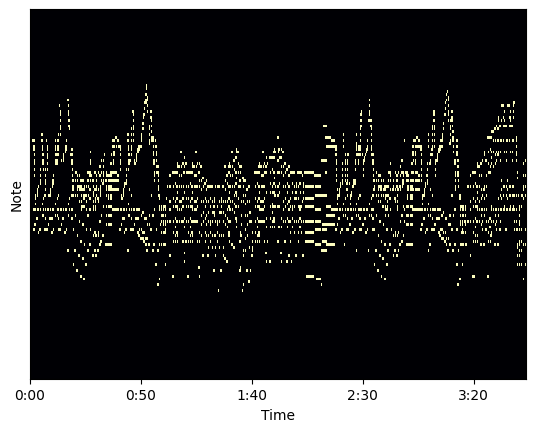

In [12]:
plot_piano_roll(perf_roll, fs)

In [13]:
score_roll = extract_piano_roll(score_path)
score_roll.shape

/home/dmgvrlv/miniconda3/envs/dcnn/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


torch.Size([16959, 128])

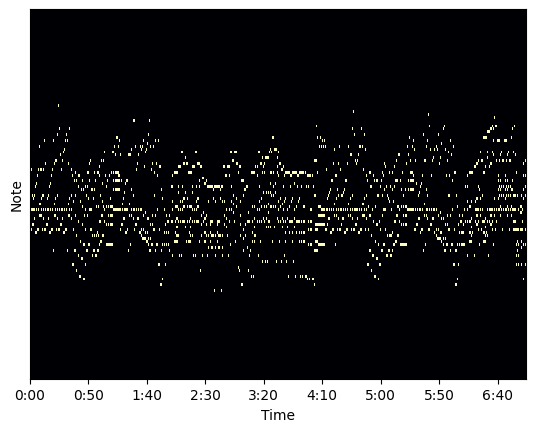

In [14]:
plot_piano_roll(score_roll, fs)

In [21]:
cross_similarity = calculate_cross_similarity(score_roll, perf_roll)
cross_similarity.shape

torch.Size([16959, 8934])

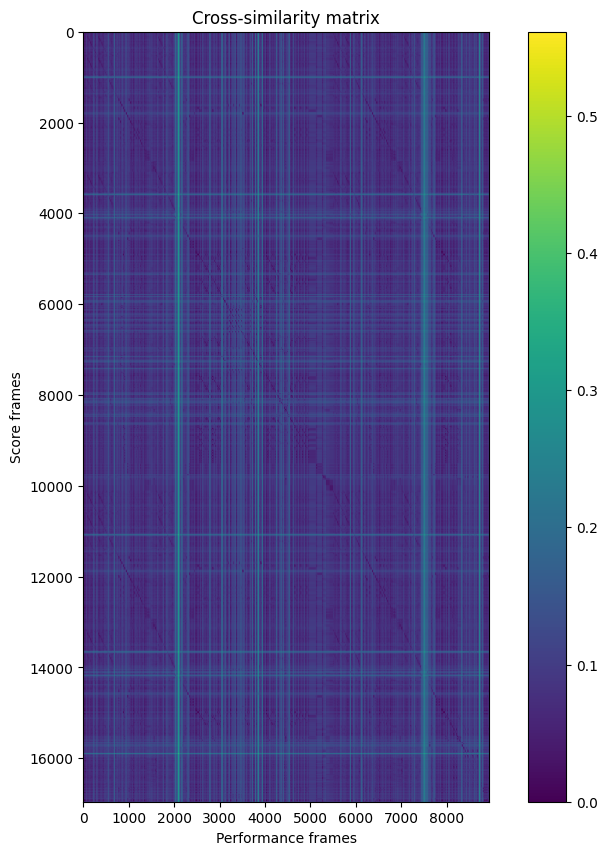

In [22]:
plot_cross_similarity(cross_similarity)

In [23]:
cross_similarity

tensor([[0.0353, 0.0353, 0.0353,  ..., 0.0911, 0.0911, 0.0911],
        [0.0353, 0.0353, 0.0353,  ..., 0.0911, 0.0911, 0.0911],
        [0.0353, 0.0353, 0.0353,  ..., 0.0911, 0.0911, 0.0911],
        ...,
        [0.0725, 0.0725, 0.0725,  ..., 0.0180, 0.0180, 0.0180],
        [0.0725, 0.0725, 0.0725,  ..., 0.0180, 0.0180, 0.0180],
        [0.0725, 0.0725, 0.0725,  ..., 0.0180, 0.0180, 0.0180]])